# План на четвер: A/B тест на CIFAR-10
## 🎯 Мета:
 Порівняти дві моделі на CIFAR-10:

 - Модель A: базова CNN без регуляризацій

- Модель B: та сама CNN з Dropout і BatchNorm

✅ Завдання:
1. Створи 2 моделі:
Модель A (Baseline):
Conv1 → ReLU → MaxPool

Conv2 → ReLU → MaxPool

FC1 → FC2

Модель B (Регуляризована):
Conv1 → BatchNorm → ReLU → MaxPool

Conv2 → ReLU → MaxPool

FC1 → Dropout → FC2

In [18]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import random
import torch.nn.functional as F


In [19]:
transform = transforms.Compose( [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 32

train_data = datasets.CIFAR10(root='data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10(root='data', train=False, download=True, transform=transform)

train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [20]:
class BaseCNN(nn.Module):
    def __init__(self):
        super(BaseCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, 3, 1, 1)

        self.fc1 = nn.Linear(32 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)  # 10 класів

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model_base = BaseCNN()
sample_input = torch.randn(1, 3, 32, 32)  
output = model_base(sample_input)
print("Output:", output.shape)  # Має бути [1, 10]


Output: torch.Size([1, 10])


In [21]:
class RegCNN(nn.Module):
    def __init__(self):
        super(RegCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.batch1 = nn.BatchNorm2d(num_features=16) 
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, 3, 1, 1)
        self.batch2 = nn.BatchNorm2d(num_features=32) 
        
        self.fc1 = nn.Linear(32 * 8 * 8, 128)
        self.drop1 = nn.Dropout(p = 0.3)
        self.fc2 = nn.Linear(128, 10) 

    def forward(self, x):
        x = self.pool(F.relu(self.batch1(self.conv1(x))))
        x = self.pool(F.relu(self.batch2(self.conv2(x))))
        x = x.view(-1, 32 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.drop1(x)
        x = self.fc2(x)
        return x

model_reg = RegCNN()
sample_input = torch.randn(1, 3, 32, 32)  
output = model_reg(sample_input)
print("Output:", output.shape)  


Output: torch.Size([1, 10])


In [22]:
criterion = nn.CrossEntropyLoss()
optimizer_1 = torch.optim.Adam(model_base.parameters(), lr=0.001) 
optimizer_2 = torch.optim.Adam(model_reg.parameters(), lr=0.001) 

epochs = 10
train_loss_values = []
train_acc_values = []

def accuracy_fn(y_true, y_pred):
    return (y_true == y_pred).sum().item() / len(y_true)

2. Навчи обидві моделі (5-10 епох):
Використай:

CrossEntropyLoss()

Adam або SGD

batch_size = 32, lr = 0.001

3. Логуй точність на train і test після кожної епохи
Можна просто print(f"Epoch {epoch+1}: Train Acc: ..., Test Acc: ...")

**первый**

In [23]:
model_base.to(device)
train_loss_values, train_acc_values = [], []
test_loss_values, test_acc_values = [], []

for epoch in range(epochs):
    # TRAIN
    model_base.train()
    running_loss, running_acc = 0.0, 0.0
    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer_1.zero_grad()
        outputs = model_base(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_1.step()

        running_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        running_acc += accuracy_fn(labels, preds)

    train_loss = running_loss / len(train_dataloader)
    train_acc = running_acc / len(train_dataloader)
    train_loss_values.append(train_loss)
    train_acc_values.append(train_acc)

    # EVAL
    model_base.eval()
    test_loss, test_acc = 0.0, 0.0
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_base(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            test_acc += accuracy_fn(labels, preds)

    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)
    test_loss_values.append(test_loss)
    test_acc_values.append(test_acc)

    print(f"Epoch {epoch+1}/{epochs} | "
            f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
            f"Test Loss: {test_loss:.4f} Acc: {test_acc:.4f}")


Epoch 1/10 | Train Loss: 1.3746 Acc: 0.5060 | Test Loss: 1.1633 Acc: 0.5875
Epoch 2/10 | Train Loss: 1.0408 Acc: 0.6300 | Test Loss: 1.0301 Acc: 0.6302
Epoch 3/10 | Train Loss: 0.9034 Acc: 0.6803 | Test Loss: 0.9736 Acc: 0.6642
Epoch 4/10 | Train Loss: 0.8078 Acc: 0.7160 | Test Loss: 0.9084 Acc: 0.6790
Epoch 5/10 | Train Loss: 0.7266 Acc: 0.7435 | Test Loss: 0.9439 Acc: 0.6777
Epoch 6/10 | Train Loss: 0.6583 Acc: 0.7665 | Test Loss: 0.8939 Acc: 0.6946
Epoch 7/10 | Train Loss: 0.5890 Acc: 0.7936 | Test Loss: 0.9367 Acc: 0.6915
Epoch 8/10 | Train Loss: 0.5318 Acc: 0.8122 | Test Loss: 0.9598 Acc: 0.6955
Epoch 9/10 | Train Loss: 0.4729 Acc: 0.8331 | Test Loss: 1.0110 Acc: 0.6959
Epoch 10/10 | Train Loss: 0.4229 Acc: 0.8489 | Test Loss: 1.0695 Acc: 0.6942


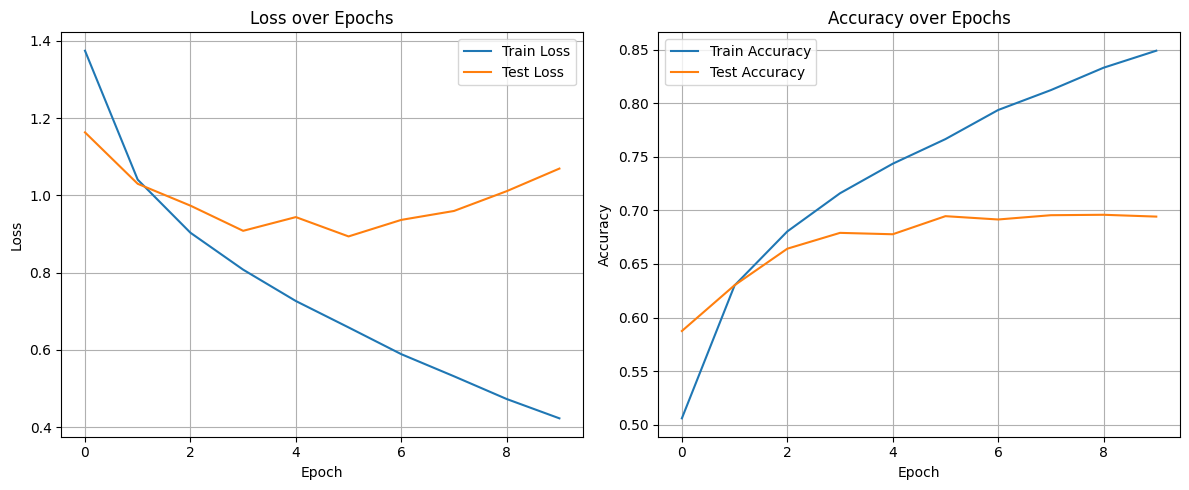

In [24]:
# PLOT
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss_values, label="Train Loss")
plt.plot(test_loss_values, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_acc_values, label="Train Accuracy")
plt.plot(test_acc_values, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

**второй**

In [25]:
model_reg.to(device)
train_loss_values, train_acc_values = [], []
test_loss_values, test_acc_values = [], []

for epoch in range(epochs):
    # TRAIN
    model_reg.train()
    running_loss, running_acc = 0.0, 0.0
    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer_2.zero_grad()
        outputs = model_reg(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_2.step()

        running_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        running_acc += accuracy_fn(labels, preds)

    train_loss = running_loss / len(train_dataloader)
    train_acc = running_acc / len(train_dataloader)
    train_loss_values.append(train_loss)
    train_acc_values.append(train_acc)

    # EVAL
    model_reg.eval()
    test_loss, test_acc = 0.0, 0.0
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_reg(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            test_acc += accuracy_fn(labels, preds)

    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)
    test_loss_values.append(test_loss)
    test_acc_values.append(test_acc)

    print(f"Epoch {epoch+1}/{epochs} | "
            f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
            f"Test Loss: {test_loss:.4f} Acc: {test_acc:.4f}")


Epoch 1/10 | Train Loss: 1.4599 Acc: 0.4695 | Test Loss: 1.1712 Acc: 0.5789
Epoch 2/10 | Train Loss: 1.1764 Acc: 0.5798 | Test Loss: 1.0165 Acc: 0.6413
Epoch 3/10 | Train Loss: 1.0763 Acc: 0.6195 | Test Loss: 0.9531 Acc: 0.6714
Epoch 4/10 | Train Loss: 0.9994 Acc: 0.6448 | Test Loss: 0.9344 Acc: 0.6666
Epoch 5/10 | Train Loss: 0.9489 Acc: 0.6639 | Test Loss: 0.8748 Acc: 0.6948
Epoch 6/10 | Train Loss: 0.9030 Acc: 0.6808 | Test Loss: 0.8666 Acc: 0.6981
Epoch 7/10 | Train Loss: 0.8676 Acc: 0.6917 | Test Loss: 0.8574 Acc: 0.6995
Epoch 8/10 | Train Loss: 0.8307 Acc: 0.7051 | Test Loss: 0.8364 Acc: 0.7066
Epoch 9/10 | Train Loss: 0.8106 Acc: 0.7096 | Test Loss: 0.8314 Acc: 0.7139
Epoch 10/10 | Train Loss: 0.7850 Acc: 0.7172 | Test Loss: 0.8321 Acc: 0.7151


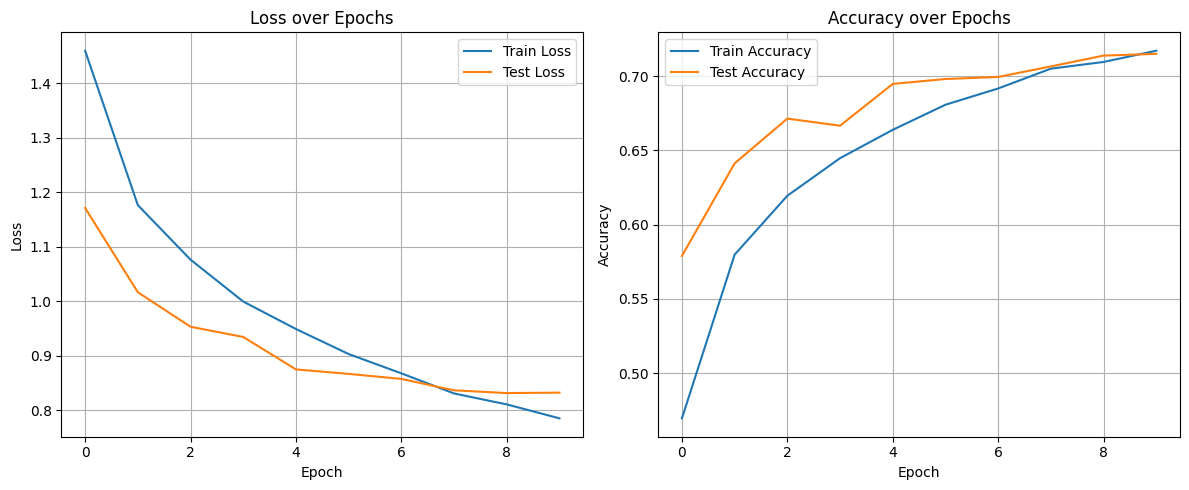

In [26]:
# PLOT
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss_values, label="Train Loss")
plt.plot(test_loss_values, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_acc_values, label="Train Accuracy")
plt.plot(test_acc_values, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

ПЕРЕОБУЧЕНИЕ у модели BaseCNN
